### Step 3

# Create geological model

#### Import Python libraries

In [1]:
import sys, warnings, numpy as np, matplotlib.pyplot as plt, gdal
sys.path.append(r"..")
import rgeomod
warnings.filterwarnings('ignore')
import gempy as gp
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/Users/flow/anaconda3/envs/remote-geomod/lib/python3.6/site-packages/gempy/data_management.py:35: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/flow/anaconda3/envs/remote-geomod/lib/python3.6/site-packages/gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


### Step 3b: Define geological model object, load the interface and foliation data files and set model extent

In [2]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50],
                        path_o = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

### Step 3c: Set stratigraphic order

<div class="alert alert-info">
**Your task:** Enter the correct ordering of formation names as strings in the list variable *order_formations* in the code cell below and execute the following code cell to set the stratigraphic order for the modeling software. The **order** of the formations should be **from youngest to oldest** in the following list:
</div>

<div class="alert alert-warning">
**Note**: you can keep the provided names, or adjust them to suit your own definitions
</div>



In [3]:
formation_order = ["Unit4", "Unit3", "Unit2", "Unit1"]

With the code in the next cell, we define the order of the geological formations and obtain an overview of the stratigraphic pile.

<div class="alert alert-warning">
**Note**: We only have one modeling "series" in this case. A series (in this modeling context) is defined as a sequence of (sub-)parallel surfaces. However, the order of the "Units" is important and should reflect the actual relative age ordering you interpret from GoogleEarth.
</div>




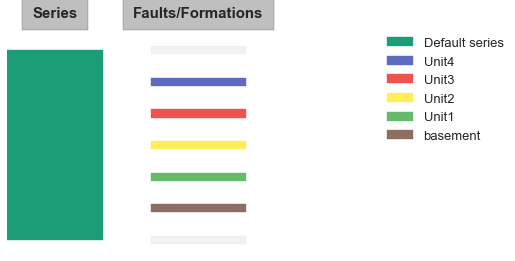

In [4]:
gp.set_series(geo_data, {"Default series": formation_order},
              order_formations = formation_order, verbose=1)

### Step 3d: create plots of raw data in map view and cross sections

<div class="alert alert-info">
**Your task:** Execute the code below to generate a plot of your picked points and processed orientation values. Note: adjust `direction="z"` to `direction="x"` or `direction="y"` to get section views in E-W and N-S directions:
</div>

<div class="alert alert-warning">
**Note**: review carefully at this step if the defined sequence order in the stratigraphic pile is correct!
</div>



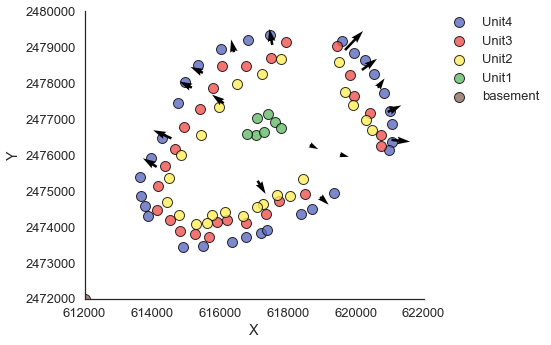

In [5]:
gp.plot_data(geo_data, direction="z")

### Step 3e (optional): visualize input data in 3-D using VTK

<div class="alert alert-info">
**Your task:** Execute the code below to generate a 3-D visualisation in an external VTK-viewer:
</div>


<div class="alert alert-danger">
**Important note (1)**: You need to **close the external viewer (press Q)** when finished with the inspection in order to continue with this workbook.
</div>

<div class="alert alert-danger">
**Important note (2)**: The VTK viewer is *interactive*: if you change a point here (you can click and drag points to move), then the position will be updated in your model, so **be careful**!
</div>

<div class="alert alert-danger">
**Important note (3)**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [6]:
try:
    gp.plot_data_3D(geo_data)
except NameError:
    print("3-D visualization library vtk not installed.")

holding... Use vtk.resume to go back to the interactive window


### Computing the 3D Model

<div class="alert alert-info">
**Your task:** Execute the following two cells to perform the model interpolation step.
</div>

<div class="alert alert-warning">
**Note**: The following code cell **will need several minutes to execute**, depending on your system configuration. As this step is compute- and memory-intense, it can also fail (you will then get a "kernal died" warning). If this happens, then check your memory settings (especially if you are using the installation in a docker container) and re-run the notebook.
</div>

In [7]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [8]:
lith_block, fault_block = gp.compute_model(interp_data)
print("3-D geological model calculated.")

3-D geological model calculated.


### Step 4

## Post-processing results for visualization and interpretation

With the following code cells, we provide several methods to generate visualizations of the generated geological model. The straight-forward way is to represent the result in a cross-section through the model. Note that, at this step, this is directly possible as we have the full interpolation in 3-D. Results can be compared to the manually created cross-section, if you performed this exercise before (von Hagke et al., submitted).

However, as the model is available in full 3-D, we can also attempt visualizations in 3-D plots. One example is implemented directly in the notebook (in a static, and therefore somewhat limited view); a better option is again to use the external VTK viewer to inspect model and data interactively in 3-D.

<div class="alert alert-warning">
**Note**: For your convenience, results will directly be saved as high-quality `pdf`-files in the `../data` directory, for further use in discussions, reports, etc.
</div>

### 2D Sections

<div class="alert alert-info">
**Your task:** Execute the following two cells to generate cross-sections in 'x'-(E-W) and 'y'-(N-S) directions:
</div>



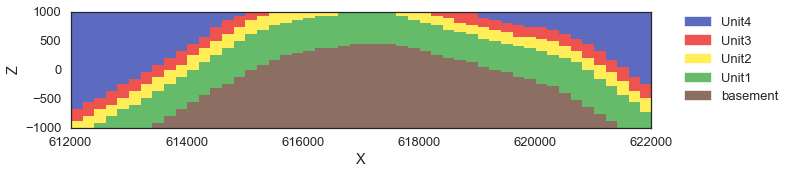

In [9]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)
plt.savefig("../data/cross_section_NS_25.pdf", bbox_inches="tight")

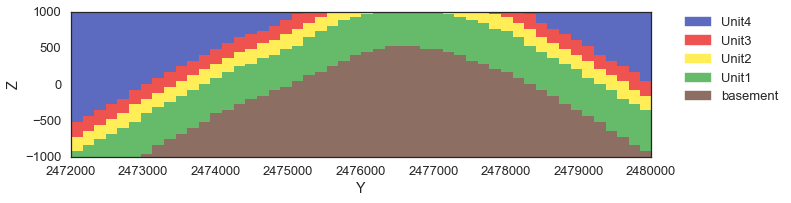

In [10]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x', plot_data=False)
plt.savefig("../data/cross_section_EW_25.pdf", bbox_inches="tight")

### Pseudo-3D surfaces

From the interpolated block model we can extract the `vertices` and `simplices` to construct layer interfaces for 3-D visualization.


<div class="alert alert-info">
**Your task:** Execute the following cells to generate a static 3-D view of the interpolated geological surfaces:
</div>



In [11]:
vertices, simplices = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

Although the main Python plotting library `matplotlib`is designed for 2-D visualization, it has some support for pseudo-3-D visualization:

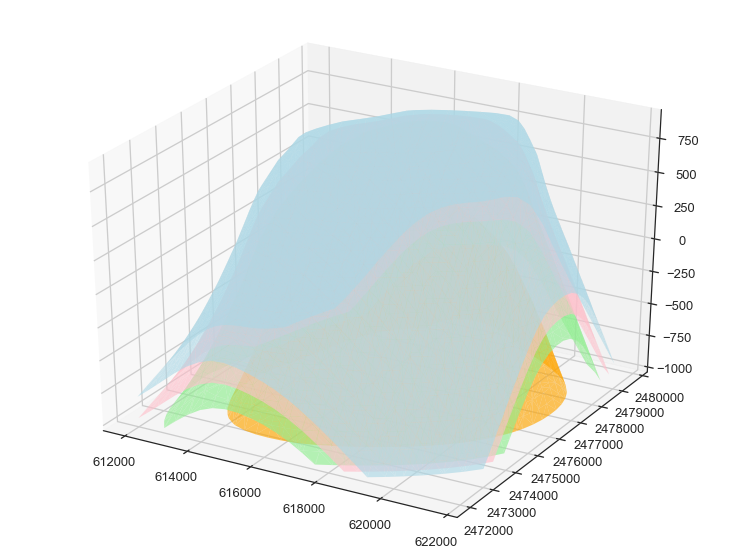

In [13]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
cs = ["lightblue", "pink", "lightgreen", "orange"]
for i in range(4):
    surf = ax.plot_trisurf(vertices[i][:,0], vertices[i][:,1], vertices[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.65, shade=False)
plt.savefig("../results/surfaces_3D.pdf", bbox_inches="tight")

### 3D Visualization using VTK

For actual 3-D visualization we can make use of the 3-D visualization library `vtk` to look at the interpolated geological model in a more intuitive and flexible way. 

<div class="alert alert-danger">
**Important note (1)**: You need to **close the external viewer** when finished with the inspection in order to continue with this workbook.
</div>

<div class="alert alert-danger">
**Important note (2)**: The VTK viewer is *interactive*: if you change a point here (you can click and drag points to move), then the position will be updated in your model, so **be careful**!
</div>

<div class="alert alert-danger">
**Important note (3)**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [14]:
try:
    gp.plot_surfaces_3D(geo_data, vertices, simplices)
except NameError:
    print("3-D visualization library vtk not installed.")

closing vtk


### Creating a geological map

We can now intersect the interpolated geological model with the digital terrain model to create a geological map. As a first step, we load the corresponding digital terrain model (DTM) for the modeling region. We then set up a new interpolation according to the topography resolution (for a correct export of the model), and as before, import the data points and define the stratigraphy. We then calculate the geological map from the intersection between geological model and terrain model. 

The generated map can be visualized again in a 2-D plot, but we also make use of the possibility to save the map in a GeoTiff-format to re-import the map back into GoogleEarth for a better inspection and interpretation of the results.

<div class="alert alert-info">
**Your task:** Load DTM data:
</div>

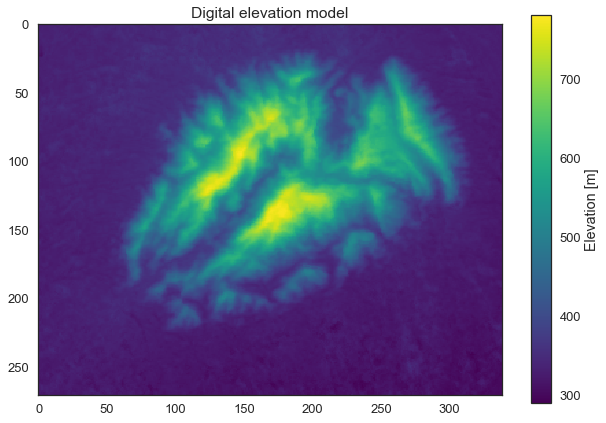

In [15]:
# load the digital elevation model
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()
dtmp = plt.imshow(dtm, origin='upper', cmap="viridis");
plt.title("Digital elevation model");
plt.colorbar(dtmp, label="Elevation [m]");
plt.savefig("../results/DTM.pdf")

<div class="alert alert-info">
**Your task:** Build basic gempy using _data_ extent (_resolution_ does not matter for the interpolation but is important for the visualization) and perform the interpolation steps with the following cells:
</div>



In [16]:
# To be able to use gempy plotting functionality we need to create a dummy geo_data object with the
# resoluion we want. In this case resolution=[339, 271, 1]
import copy
geo_data_dummy = copy.deepcopy(geo_data)
geo_data_dummy.resolution = [339, 271, 1]

In [17]:
# convert the dtm to a gempy-suitable raveled grid
points = rgeomod.convert_dtm_to_gempy_grid(raster, dtm)

Now we can use the function `compute_model_at` to get the lithology values at a specific location:

In [18]:
# interp_data_geomap = gp.InterpolatorInput(geo_data, dtype="float64")
lith_block, fault_block = gp.compute_model_at(points, interp_data)

<div class="alert alert-info">
**Your task:** Create a visual representation of the geological map in a 2-D plot (note: result is also again saved to the `../data`-folder):
</div>

And here **the geological map**:

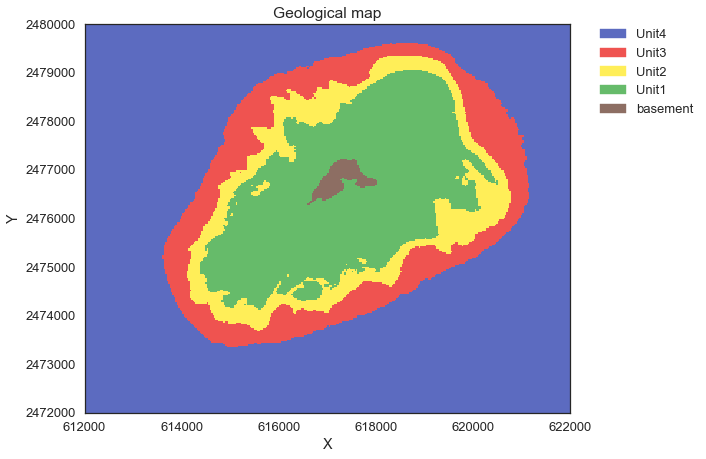

In [20]:
gp.plot_section(geo_data_dummy, lith_block[0], 0, direction='z', plot_data=False)
plt.title("Geological map");
plt.savefig("../results/geological_map.pdf")

### Export the map for visualization in GoogleEarth

<div class="alert alert-info">
**Your task:** Execute the following code to export a GeoTiff of the generated geological map, as well as `kml`-files with your picked points inside the data folder. Open these files in GoogleEarth and inspect the generated map:
</div>


<div class="alert alert-warning">
**Note (1)**: Use the normal `File -> Open..` dialog in GoogleEarth to open the data - no need to use the `Import` method, as the GeoTiff contains the correct coordinates in the file.
</div>


<div class="alert alert-warning">
**Note (2)**: For a better interpretation of the generated map, use the transparency feature (directly after opening the map, or using `right-click -> Get Info` on the file).
</div>

In [21]:
geo_map = lith_block[0].copy().reshape((339,271))
geo_map = geo_map.astype('int16')  # change to int for later use

In [22]:
rgeomod.export_geotiff("../results/geomap.tif", geo_map, gp.plotting.colors.cmap, geotiff_filepath)

Successfully exported geological map to ../results/geomap.tif


Export the interface data points:

In [23]:
t = "../rgeomod/templates/ge_template_raw_interf.xml"
pt = "../rgeomod/templates/ge_placemark_template_interf.xml"
rgeomod.gempy_export_points_to_kml("../results/", geo_data, pt, t, gp.plotting.colors.cmap)

Export the foliation data:

In [24]:
t = "../rgeomod/templates/ge_template_raw_fol.xml"
pt = "../rgeomod/templates/ge_placemark_template_fol.xml"
rgeomod.gempy_export_fol_to_kml("../results/dips.kml", geo_data, pt, t)